In [1]:
# 이미지분류 신경망
#LeNet-5 : 합성곱 신경망의 최초 구조
# 합성곱과 다운샘플링을 반복.. 마지막에 완전 연결층에서 분류 수행

In [ ]:
# C1에서 5x5 합성곱 연산후 28x28크기의 특성맵 여섯개 생성
# S2에서 다운 샘플링 맵 크기를 14x14로 줄임
# C3는 5x5 합성곱 연산후 10x10크기의 특성맵 16 생성

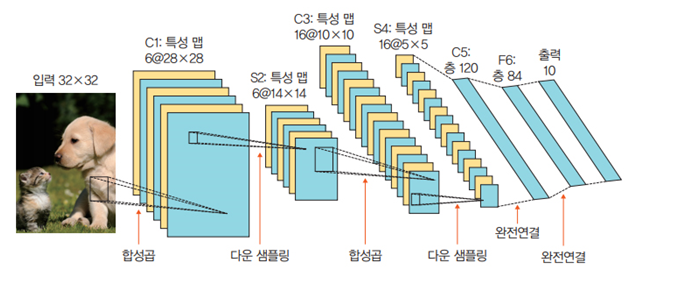

In [ ]:
# LeNet-5를 사용하는 예제
# 데이터는 개 고양이

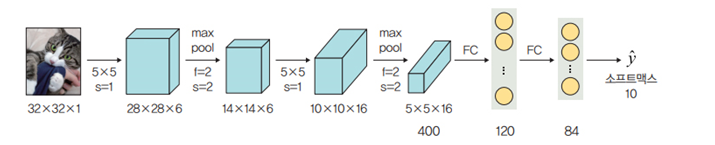

In [ ]:
# 상세 설계안

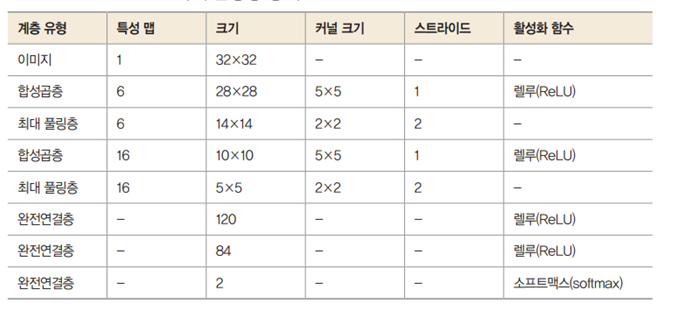

In [3]:
# 진행상황을 시각화 하기위해
!pip install --user tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#라이브러리 셋팅
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
import matplotlib.pyplot as plt


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# 데이터 전처리 - 텐서변환, 
class ImageTransform():
  def __init__(self,resize,mean,std) -> None:
    self.data_transform = {
        'train' : transforms.Compose(
            [
             transforms.RandomResizedCrop(resize,scale=(0.5,1.0)),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),  # 이미지를 텐서형태로변경  픽셀의 범위가 0.0~1.0되고 차원은 (c,h,w)
             transforms.Normalize(mean,std) # 전이학습에서 사용되는 모델은 대부분 ImageNet데이터 셋에서 훈련, 데이터를 정규화
             # 주의점... ImageNet에서 이미지는 RGB채널 마다 평균과 표준편차를 의미
             # OpenCv를 이용해서 이미지를 읽어오면 RGB가 아니라 BGR 이미지이므로 채널 순서에 주의             
            ]
        ),
        'val': transforms.Compose(
            [
             transforms.Resize(256),
             transforms.CenterCrop(resize),
             transforms.ToTensor(),
             transforms.Normalize(mean,std)             
            ]
        )
    }
  def __call__(self, img,phase):   # 클래스를 호출할 수 있도록 하는 메서드  객체가 호출되었을때 실행되는 메서드
    return self.data_transform[phase](img)

In [8]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()

Saving catanddog.zip to catanddog.zip


In [ ]:
!unzip catanddog.zip -d dogs-vs-cats/

In [10]:
cat_directory = 'dogs-vs-cats/train/Cat'
dog_directory = 'dogs-vs-cats/train/Dog'

In [13]:
from glob import glob

In [17]:
cat_images_filepaths = sorted(glob(cat_directory+"/*.jpg"))
dog_images_filepaths = sorted(glob(dog_directory+"/*.jpg"))

In [32]:
images_filepaths = [*cat_images_filepaths,*dog_images_filepaths]  # len(cat_images_filepaths+dog_images_filepaths)

In [33]:
# 이미지경로에 있는 이미지가 실제 이미지 인지 확인
correct_images_filepath = [i for i in images_filepaths if cv2.imread(i) is not None]

In [34]:
len(correct_images_filepath)

385

In [37]:
random.seed(42)
random.shuffle(correct_images_filepath)
#훈련용 데이터, 검증용 데이터 8:2로 분할
split_size = int(len(correct_images_filepath) * 0.8)

train_images_filepaths = correct_images_filepath[:split_size]
val_images_filepaths = correct_images_filepath[split_size:-10]
test_images_filepaths = correct_images_filepath[-10:]
len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths)

(308, 67, 10)

In [40]:
# 데이터셋 이미지 확인 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
  rows = len(images_filepaths) // cols
  figure,ax =  plt.subplots(nrows = rows, ncols = cols, figsize=(12,6))
  for i,imagepath in enumerate(images_filepaths):
    image = cv2.imread(imagepath)
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)  #  BGR -- >RGB
    true_label = os.path.normpath(imagepath).split(os.sep)[-2]
    predicted_label = predicted_labels[i] if predicted_labels else true_label
    color = 'green' if true_label == predicted_label else 'red'
    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(predicted_label,color=color)
    ax.ravel()[i].set_axis_off()
  plt.tight_layout() # 이미지 여백조정
  plt.show()



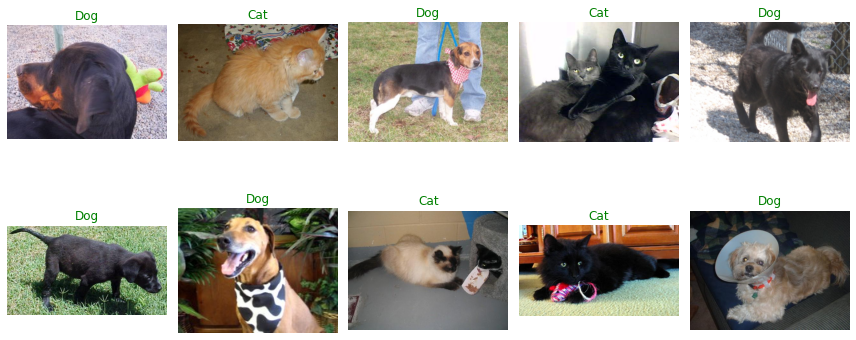

In [41]:
display_image_grid(test_images_filepaths)